In [1]:
# =============================================
# DATA MINING PROJECT: CUSTOMER SEGMENTATION
# METHODOLOGY: CRISP-DM (PCA + K-MEANS)
# =============================================

# --------------------------
# 1. LIBRARIES & SETUP 
# --------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Modern style configuration
plt.style.use('default')  # Reset to default first
sns.set_style("whitegrid")
sns.set_palette("viridis")
%matplotlib inline


In [2]:
# --------------------------
# 2. BUSINESS UNDERSTANDING
# --------------------------
"""
PROJECT OBJECTIVES:
1. Identify customer segments based on purchasing behavior
2. Analyze product price distribution patterns
3. Provide actionable insights for marketing strategy

DATA SOURCE: (https://www.kaggle.com/code/fabiendaniel/customer-segmentation/input)
ANALYTIC METHODS: 
- Principal Component Analysis (PCA)
- K-Means Clustering
- RFM (Recency, Frequency, Monetary) Analysis
"""

'\nPROJECT OBJECTIVES:\n1. Identify customer segments based on purchasing behavior\n2. Analyze product price distribution patterns\n3. Provide actionable insights for marketing strategy\n\nDATA SOURCE: (https://www.kaggle.com/code/fabiendaniel/customer-segmentation/input)\nANALYTIC METHODS: \n- Principal Component Analysis (PCA)\n- K-Means Clustering\n- RFM (Recency, Frequency, Monetary) Analysis\n'

In [3]:
# --------------------------
# 3. DATA LOADING & CLEANING
# --------------------------
def load_data(filepath):
    encodings = ['utf-8', 'latin1', 'ISO-8859-1', 'cp1252']
    
    for encoding in encodings:
        try:
            df = pd.read_csv(filepath, encoding=encoding)
            print(f"✅ Success with {encoding} encoding")
            return df
        except UnicodeDecodeError:
            continue
        except Exception as e:
            print(f"⚠️ Unexpected error with {encoding}: {str(e)}")
            continue
    
    try:
        import chardet
        with open(filepath, 'rb') as f:
            result = chardet.detect(f.read(100000))
        df = pd.read_csv(filepath, encoding=result['encoding'])
        print(f"✅ Used chardet-detected {result['encoding']} encoding")
        return df
    except:
        print("❌ All attempts failed. Trying last resort...")
        try:
            df = pd.read_csv(filepath, encoding='utf-8', errors='replace')
            print("⚠️ Loaded with some characters replaced")
            return df
        except Exception as e:
            raise ValueError(f"Fatal error: {str(e)}")

try:
    df = load_data('data.csv')
    print(f"Shape: {df.shape}\n")
except Exception as e:
    print(f"❌ Critical failure: {str(e)}")
    exit()

✅ Success with latin1 encoding
Shape: (541909, 8)



In [4]:
# --------------------------
# 4. DATA UNDERSTANDING (CRISP-DM PHASE 1)
# --------------------------
print("="*50)
print("DATA UNDERSTANDING")
print("="*50)

DATA UNDERSTANDING


In [5]:
# Basic inspection
print("\n📋 Dataset info:")
print(df.info())


📋 Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [6]:
print("\n🧮 Descriptive statistics:")
display(df.describe().transpose())


🧮 Descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [7]:
# Missing values analysis
print("\n🔍 Missing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])


🔍 Missing values:
Description      1454
CustomerID     135080
dtype: int64


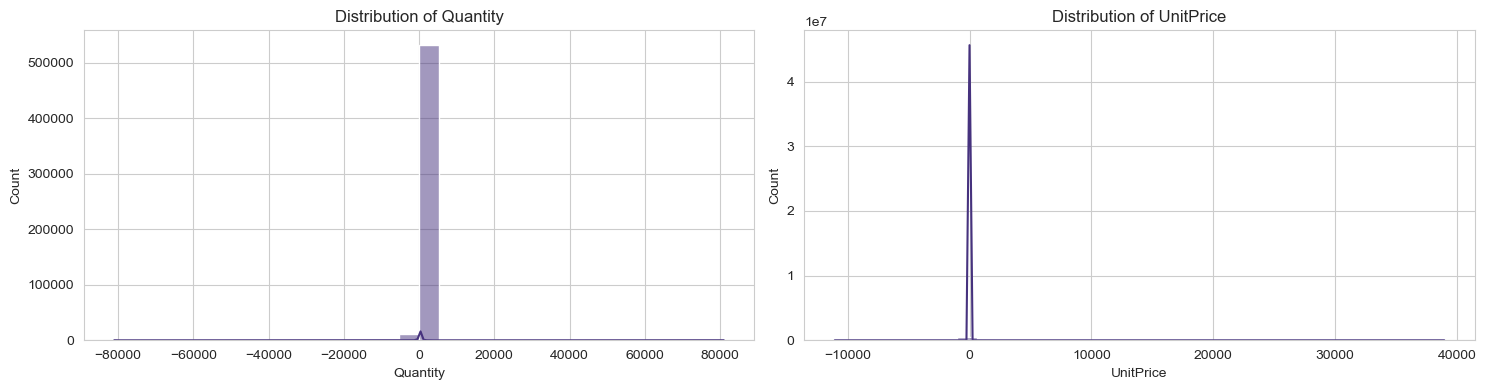

In [8]:
# Visual EDA
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'CustomerID' in numeric_cols:
    numeric_cols.remove('CustomerID')
    plt.figure(figsize=(15, 4))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [9]:
# --------------------------
# 5. DATA PREPARATION
# --------------------------
print("\n" + "="*50)
print("DATA PREPARATION PHASE")
print("="*50)

# Clean data
print("\n🧹 Cleaning data...")
df_clean = df.copy()
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['Quantity'] <= 50)]
df_clean = df_clean[(df_clean['UnitPrice'] > 0) & (df_clean['UnitPrice'] <= 20)]

# Create RFM features
print("\n🔄 Creating RFM features...")
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'UnitPrice': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'UnitPrice': 'Monetary'
})



DATA PREPARATION PHASE

🧹 Cleaning data...

🔄 Creating RFM features...



MODELING PHASE

🔮 Applying PCA...
Explained variance ratio: [0.61868352 0.29460928]

📊 Determining optimal clusters...


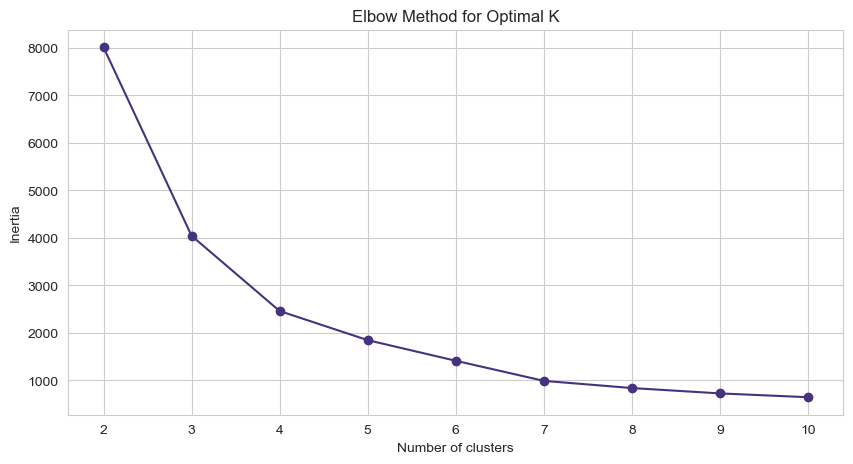

In [10]:
# --------------------------
# 6. MODELING (PCA + K-MEANS)
# --------------------------
print("\n" + "="*50)
print("MODELING PHASE")
print("="*50)

# Standardize data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# PCA
print("\n🔮 Applying PCA...")
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Determine optimal clusters
print("\n📊 Determining optimal clusters...")
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Final clustering
optimal_k = 3  # Set based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_pca)

In [11]:

# --------------------------
# 7. EVALUATION
# --------------------------
print("\n" + "="*50)
print("EVALUATION PHASE")
print("="*50)

# Silhouette score
print(f"\n📐 Silhouette Score: {silhouette_score(rfm_pca, rfm['Cluster']):.3f}")

# Cluster profiles
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2)

print("\n👥 Cluster Profiles:")
display(cluster_profile)


EVALUATION PHASE

📐 Silhouette Score: 0.573

👥 Cluster Profiles:


Recency Frequency  Monetary      
           mean      mean      mean count
Cluster                                  
0         40.19      4.79    289.95  3156
1        243.70      1.57     87.71  1095
2          1.86    116.86  12332.95     7

In [12]:
# --------------------------
# 8. DEPLOYMENT
# --------------------------
print("\n" + "="*50)
print("DEPLOYMENT PHASE")
print("="*50)



DEPLOYMENT PHASE


In [13]:
# Visualization
plt.figure(figsize=(15,6))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

Text(0, 0.5, 'PCA Component 2')

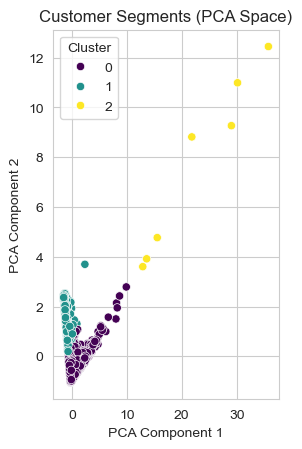

In [14]:
# PCA plot
plt.subplot(1,2,1)
sns.scatterplot(x=rfm_pca[:,0], y=rfm_pca[:,1], hue=rfm['Cluster'], palette='viridis')
plt.title('Customer Segments (PCA Space)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

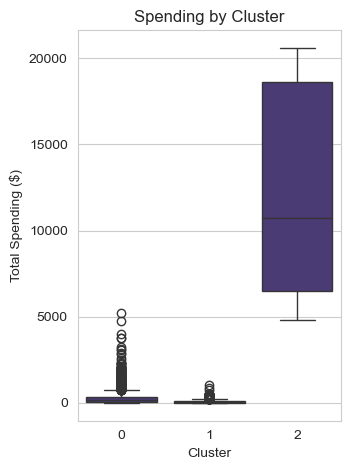

In [15]:
# Monetary value by cluster
plt.subplot(1,2,2)
sns.boxplot(x='Cluster', y='Monetary', data=rfm)
plt.title('Spending by Cluster')
plt.ylabel('Total Spending ($)')
plt.tight_layout()
plt.savefig('customer_segments.png', dpi=300)
plt.show()

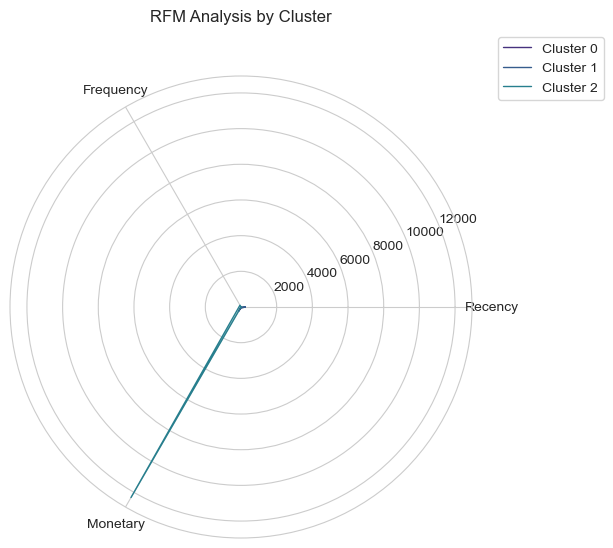

In [16]:
# RFM radar chart
def plot_radar_chart(data):
    categories = ['Recency','Frequency','Monetary']
    N = len(categories)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    
    for cluster in sorted(data['Cluster'].unique()):
        values = data[data['Cluster']==cluster][categories].mean().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, label=f'Cluster {cluster}')
        ax.fill(angles, values, alpha=0.1)
    
    plt.xticks(angles[:-1], categories)
    plt.title('RFM Analysis by Cluster', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.savefig('rfm_radar.png', dpi=300, bbox_inches='tight')

plot_radar_chart(rfm)

In [17]:
# Export results
rfm.to_csv('customer_segments.csv')
print("\n💾 Results exported to 'customer_segments.csv'")


💾 Results exported to 'customer_segments.csv'


In [18]:
# --------------------------
# 9. REPORT GENERATION
# --------------------------
print("""
📄 REPORT COMPONENTS READY:
1. Data Quality Report (missing values, distributions)
2. PCA Variance Explanation
3. Cluster Profiles (statistics)
4. Visualizations:
   - customer_segments.png
   - rfm_radar.png
5. Processed dataset (customer_segments.csv)
""")


📄 REPORT COMPONENTS READY:
1. Data Quality Report (missing values, distributions)
2. PCA Variance Explanation
3. Cluster Profiles (statistics)
4. Visualizations:
   - customer_segments.png
   - rfm_radar.png
5. Processed dataset (customer_segments.csv)

